In [1]:
%matplotlib inline


Link Prediction using Graph Neural Networks
===========================================

In the :doc:`introduction <1_introduction>`, you have already learned
the basic workflow of using GNNs for node classification,
i.e. predicting the category of a node in a graph. This tutorial will
teach you how to train a GNN for link prediction, i.e. predicting the
existence of an edge between two arbitrary nodes in a graph.

By the end of this tutorial you will be able to

-  Build a GNN-based link prediction model.
-  Train and evaluate the model on a small DGL-provided dataset.

(Time estimate: 28 minutes)


In [24]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Overview of Link Prediction with GNN
------------------------------------

Many applications such as social recommendation, item recommendation,
knowledge graph completion, etc., can be formulated as link prediction,
which predicts whether an edge exists between two particular nodes. This
tutorial shows an example of predicting whether a citation relationship,
either citing or being cited, between two papers exists in a citation
network.

This tutorial formulates the link prediction problem as a binary classification
problem as follows:

-  Treat the edges in the graph as *positive examples*.
-  Sample a number of non-existent edges (i.e. node pairs with no edges
   between them) as *negative* examples.
-  Divide the positive examples and negative examples into a training
   set and a test set.
-  Evaluate the model with any binary classification metric such as Area
   Under Curve (AUC).

<div class="alert alert-info"><h4>Note</h4><p>The practice comes from
   `SEAL <https://papers.nips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf>`__,
   although the model here does not use their idea of node labeling.</p></div>

In some domains such as large-scale recommender systems or information
retrieval, you may favor metrics that emphasize good performance of
top-K predictions. In these cases you may want to consider other metrics
such as mean average precision, and use other negative sampling methods,
which are beyond the scope of this tutorial.

Loading graph and features
--------------------------

加载数据集




In [60]:
import dgl.data
dataset_name = "pubmed"
if dataset_name == 'cora':
    dataset = dgl.data.CoraGraphDataset()
elif dataset_name == 'citeseer':
    dataset = dgl.data.CiteseerGraphDataset()
elif dataset_name == 'pubmed':
    dataset = dgl.data.PubmedGraphDataset()
else:
    raise ValueError('Unknown dataset: {}'.format(args.dataset))

g = dataset[0]

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Prepare training and testing sets
---------------------------------
- test_p/n  = 0.1 * dataset
- val_p/n   = 0.2 * dataset
- train_p/n = 0.7 * dataset

正负样本的数量相同，保证正负样本均衡。




In [61]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
val_size = int(len(eids) * 0.2)
train_size = g.number_of_edges() - test_size - val_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
val_pos_u, val_pos_v = u[eids[test_size: test_size+val_size]], v[eids[test_size: test_size+val_size]]
train_pos_u, train_pos_v = u[eids[test_size+val_size:]], v[eids[test_size+val_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))  # coo_matrix: 矩阵中的值，以及这些值在矩阵中的索引，未指定执形状时从中推断出来
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())  # 选择与正样本数相同大负样本数，保证正负样本均衡
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
val_neg_u, val_neg_v = neg_u[neg_eids[test_size: test_size+val_size]], neg_v[neg_eids[test_size: test_size+val_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size::]], neg_v[neg_eids[test_size+val_size::]]

MemoryError: Unable to allocate 2.90 GiB for an array with shape (19717, 19717) and data type float64

When training, you will need to remove the edges in the test set from
the original graph. You can do this via ``dgl.remove_edges``.

<div class="alert alert-info"><h4>Note</h4><p>``dgl.remove_edges`` works by creating a subgraph from the
   original graph, resulting in a copy and therefore could be slow for
   large graphs. If so, you could save the training and test graph to
   disk, as you would do for preprocessing.</p></div>




In [29]:
train_g = dgl.remove_edges(g, eids[:test_size+val_size])

Define a GraphSAGE model
------------------------

This tutorial builds a model consisting of two
`GraphSAGE <https://arxiv.org/abs/1706.02216>`__ layers, each computes
new node representations by averaging neighbor information. DGL provides
``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.




In [6]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

The model then predicts the probability of existence of an edge by
computing a score between the representations of both incident nodes
with a function (e.g. an MLP or a dot product), which you will see in
the next section.

\begin{align}\hat{y}_{u\sim v} = f(h_u, h_v)\end{align}




Positive graph, negative graph, and ``apply_edges``
---------------------------------------------------

In previous tutorials you have learned how to compute node
representations with a GNN. However, link prediction requires you to
compute representation of *pairs of nodes*.

DGL recommends you to treat the pairs of nodes as another graph, since
you can describe a pair of nodes with an edge. In link prediction, you
will have a *positive graph* consisting of all the positive examples as
edges, and a *negative graph* consisting of all the negative examples.
The *positive graph* and the *negative graph* will contain the same set
of nodes as the original graph.  This makes it easier to pass node
features among multiple graphs for computation.  As you will see later,
you can directly fed the node representations computed on the entire
graph to the positive and the negative graphs for computing pair-wise
scores.

The following code constructs the positive graph and the negative graph
for the training set and the test set respectively.




In [30]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes())
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes())

The benefit of treating the pairs of nodes as a graph is that you can
use the ``DGLGraph.apply_edges`` method, which conveniently computes new
edge features based on the incident nodes’ features and the original
edge features (if applicable).

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.




In [32]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))  # apply_edge函数作用在每一条边上
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

You can also write your own function if it is complex.
For instance, the following module produces a scalar score on each edge
by concatenating the incident nodes’ features and passing it to an MLP.




In [33]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

<div class="alert alert-info"><h4>Note</h4><p>The builtin functions are optimized for both speed and memory.
   We recommend using builtin functions whenever possible.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>If you have read the :doc:`message passing
   tutorial <3_message_passing>`, you will notice that the
   argument ``apply_edges`` takes has exactly the same form as a message
   function in ``update_all``.</p></div>




Training loop
-------------

After you defined the node representation computation and the edge score
computation, you can go ahead and define the overall model, loss
function, and evaluation metric.

The loss function is simply binary cross entropy loss.

\begin{align}\mathcal{L} = -\sum_{u\sim v\in \mathcal{D}}\left( y_{u\sim v}\log(\hat{y}_{u\sim v}) + (1-y_{u\sim v})\log(1-\hat{y}_{u\sim v})) \right)\end{align}

The evaluation metric in this tutorial is AUC.




In [34]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

The training loop goes as follows:

<div class="alert alert-info"><h4>Note</h4><p>This tutorial does not include evaluation on a validation
   set. In practice you should save and evaluate the best model based on
   performance on the validation set.</p></div>




In [35]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
epoches = 100
all_logits = []
train_loss = []
val_loss = []
import tqdm
progress = tqdm.tqdm(range(epoches))
for e in progress:
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
#         print('In epoch {}, loss: {}'.format(e, loss))
        with torch.no_grad():
            pos_score = pred(val_pos_g, h)
            neg_score = pred(val_neg_g, h)
            v_loss = compute_loss(pos_score, neg_score)
            val_loss.append(v_loss.item())
        progress.set_description(f"In epoch {e}, train loss :{loss}, val loss :{v_loss}")
            

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))
    


# Thumbnail Courtesy: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 95, train loss :0.46571260690689087, val loss :0.5018027424812317: 100%|████| 100/100 [00:06<00:00, 15.46it/s]

AUC 0.9062661740992368


In [36]:
# 可视化结果
from sklearn.metrics import roc_curve
scores = torch.cat([pos_score, neg_score]).numpy()
labels = torch.cat(
    [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
fpr, tpr, threshold = roc_curve(labels, scores)
roc_auc = compute_auc(pos_score, neg_score)

print(fpr[:10], tpr[:10], threshold[:10])

[0.         0.         0.         0.         0.         0.0001128
 0.0001128  0.00022561 0.00022561 0.00022561] [0.         0.0001128  0.00248167 0.00270728 0.00688099 0.00688099
 0.00733221 0.00733221 0.00767061 0.00789622] [7.241718  6.241718  5.449181  5.429465  5.174241  5.1722255 5.153059
 5.14874   5.1344213 5.1287584]


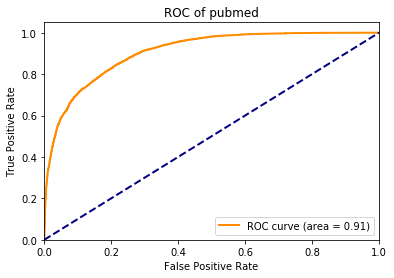

In [46]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC of {dataset_name}')
plt.legend(loc="lower right")
plt.show()

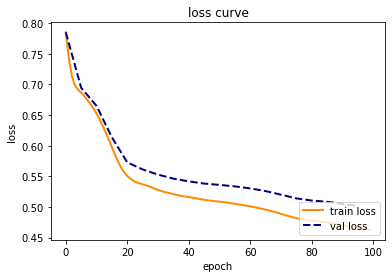

In [42]:
plt.figure()
lw = 2
plt.plot(range(epoches), train_loss, color='darkorange',
         lw=lw, label='train loss')
plt.plot(range(0, epoches, 5), val_loss, color='navy', lw=lw, linestyle='--', label='val loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss curve')
plt.legend(loc="lower right")
plt.show()

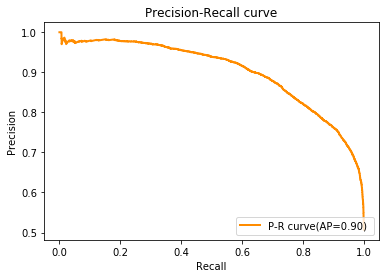

In [58]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(labels, scores)
ap = average_precision_score(labels, scores)
plt.figure()
plt.plot(recall, precision, color='darkorange',
         lw=lw, label=f'P-R curve(AP={ap:.2f}) ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

# 一个简单的总结
在link-prediction任务中，在graph上进行message passing，更新结点的特征。  
为了预测两个结点之间是否有link，或有link的概率，假设预测link的这个函数是$f$。  
可以以这两个结点的特征作为$f$的输入，则$f(u, v)$即为结点对$(u, v)$之间link的概率。可以采用二分类交叉熵作为损失函数。  

## 正负样本构造
在训练时，正样本可以使用原graph中已经存在的边，**那负样本呢？**  
其实也很显然，那就是原graph中不存在边的结点对作为负样本。

## 训练
回顾一下整个流程。  
1. 拿到一个图$g$
2. 选择其中10%的边为测试集，剩下的为训练集
3. 因为测试集在训练时应该是不可见的，故移除测试集中的边得到train_g
4. 为了利用dgl的函数计算正负样本的score，分别构造train_pos_g, train_neg_g, test_pos_g, test_neg_g, val_pos_g, val_neg_g
5. 在train_g上进行message passing
6. 计算train_pos_g, train_neg_g中结点对之间的score
7. 计算损失函数 ==> 更新模型 
8. 回到5，直至满足迭代次数

注意，在4中构建的train_pos_g, train_neg_g, test_pos_g, test_neg_g, test_neg_g, val_pos_g, val_neg_g本质上是可以不需要的，可以依次取出正负样本，逐个计算它们的score。
